In [1]:
import pandas as pd
from notebooks.consts import *

csv_path = NOTEBOOK_PATH / 'data' / 'data_asoptimizer_updated.csv'
all_data = pd.read_csv(str(csv_path), low_memory=False)

In [2]:
from notebooks.notebook_utils import log_correction, get_unique_human_genes

# Remove rows with missing values in the INHIBITION column
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
# Create a new column with transformed inhibition values on a negative log scale
log_correction(all_data_no_nan)  # to avoid log 0
genes_u = get_unique_human_genes(all_data_no_nan)


In [3]:
from notebooks.notebook_utils import read_cached_gene_to_data

gene_to_data = read_cached_gene_to_data(genes_u)


In [4]:
from tauso.new_model.data_handling import get_populated_df_with_structure_features

# Filter the data to include only rows where the cell line organism is human
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']

# Filter data to keep only rows with valid gene information
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

all_data_human_gene = get_populated_df_with_structure_features(all_data_human_gene, genes_u, gene_to_data)

In [5]:
import numpy as np
import pandas as pd
import subprocess
import tempfile
import os
import shutil
from Bio.Seq import Seq
from scipy.stats import spearmanr
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
from typing import Tuple, Dict, Optional, Any

# --- CONFIGURATION & CONSTANTS ---
CONTEXT_WINDOW = 200
SFOLD_PROB_COLUMN_INDEX = 3
SFOLD_BINARY = "sfold"  # Ensure 'sfold' is in your PATH


def process_single_aso(aso_seq: str, full_mrna: str) -> Tuple[float, str]:
    """
    Returns:
        (avg_score, status_message):
        - If success: (score, "Success")
        - If failure: (NaN, "Error: <reason>")
    """
    try:
        # 1. Find Binding Site
        target_binding_site = str(Seq(aso_seq).reverse_complement())
        start_pos_global = full_mrna.find(target_binding_site)

        if start_pos_global == -1:
            return np.nan, "Error: Binding site not found in mRNA"

        end_pos_global = start_pos_global + len(target_binding_site)

        # 2. Extract Context Window
        w_start = max(0, start_pos_global - CONTEXT_WINDOW)
        w_end = min(len(full_mrna), end_pos_global + CONTEXT_WINDOW)
        subsequence = full_mrna[w_start: w_end]

        # 3. Run Sfold
        temp_dir_base = "/dev/shm" if os.path.exists("/dev/shm") else None

        with tempfile.TemporaryDirectory(dir=temp_dir_base) as tmpdirname:
            input_path = os.path.join(tmpdirname, "input.fa")
            with open(input_path, "w") as f:
                f.write(f">win\n{subsequence}\n")

            cmd = f"{SFOLD_BINARY} -o {tmpdirname} {input_path}"

            try:
                subprocess.run(
                    cmd,
                    shell=True,
                    check=True,
                    stdout=subprocess.DEVNULL,
                    stderr=subprocess.DEVNULL
                )
            except subprocess.CalledProcessError:
                return np.nan, "Error: sfold binary execution failed"

            # 4. Parse Output
            target_file = os.path.join(tmpdirname, 'sstrand.out')
            if not os.path.exists(target_file):
                return np.nan, "Error: sstrand.out file not generated"

            probs = []
            with open(target_file, 'r') as f:
                for line in f:
                    parts = line.split()
                    if len(parts) > 4 and parts[0].isdigit():
                        try:
                            probs.append(float(parts[SFOLD_PROB_COLUMN_INDEX]))
                        except ValueError:
                            continue

            if not probs:
                return np.nan, "Error: Parsed probability list is empty"

            profile = np.array(probs)

        # 5. Calculate Score
        local_start = start_pos_global - w_start
        local_end = local_start + len(target_binding_site)

        if local_end <= len(profile):
            region_probs = profile[local_start: local_end]
            return np.mean(region_probs), "Success"
        else:
            return np.nan, f"Error: Index out of bounds (Profile len: {len(profile)}, req end: {local_end})"

    except Exception as e:
        return np.nan, f"Error: Uncaught exception ({str(e)})"


# --- MAIN WRAPPER FUNCTION ---
def calculate_sfold_accessibility(
        df: pd.DataFrame,
        gene_to_mrna_map: Dict[str, Any],
        gene_col: str = 'canonical_gene_name',
        seq_col: str = 'sequence',
        score_col: str = 'sfold_accessibility',
        error_col: str = 'sfold_error',  # <--- New column for error messages
        n_cores: Optional[int] = None
) -> pd.DataFrame:
    # ... (CPU setup code remains same) ...
    if n_cores is None:
        n_cores = max(1, os.cpu_count() - 2)

    if shutil.which(SFOLD_BINARY) is None:
        raise RuntimeError(f"The '{SFOLD_BINARY}' executable was not found in PATH.")

    tasks = []
    unique_genes = df[gene_col].unique()

    for gene in unique_genes:
        if gene not in gene_to_mrna_map:
            continue

        gene_obj = gene_to_mrna_map[gene]
        full_seq = gene_obj.full_mrna if hasattr(gene_obj, "full_mrna") else str(gene_obj)

        # Check if sequence is valid before processing
        if not full_seq or len(full_seq) < 10:
            continue  # Or handle as error later

        gene_mask = df[gene_col] == gene
        for idx, row in df[gene_mask].iterrows():
            aso_seq = row[seq_col].strip().upper()
            tasks.append((idx, aso_seq, full_seq))

    print(f"Queueing {len(tasks)} jobs on {n_cores} cores...")

    # Initialize columns
    if score_col not in df.columns:
        df[score_col] = np.nan
    df[error_col] = "Pending"  # Default state

    # Run Parallel Execution
    results_map = {}

    with ProcessPoolExecutor(max_workers=n_cores) as executor:
        future_to_idx = {
            executor.submit(process_single_aso, t[1], t[2]): t[0]
            for t in tasks
        }

        for future in tqdm(as_completed(future_to_idx), total=len(tasks), desc="Sfold Analysis"):
            idx = future_to_idx[future]
            try:
                score, message = future.result()
                results_map[idx] = (score, message)
            except Exception as e:
                results_map[idx] = (np.nan, f"Error: Critical wrapper failure ({str(e)})")

    print("Updating DataFrame...")

    # Update both score and error columns
    # Using a list comprehension is often faster than .at inside a loop for large DFs,
    # but this loop is safe for partial updates.
    for idx, (score, msg) in results_map.items():
        df.at[idx, score_col] = score
        df.at[idx, error_col] = msg

    return df


# --- EXAMPLE USAGE ---
if __name__ == "__main__":
    # ---------------------------------------------------------
    # MOCK DATA FOR DEMONSTRATION (Replace with your actual data imports)
    # ---------------------------------------------------------

    # Assuming 'all_data_human_gene' and 'gene_to_data' are defined in your environment
    # Here is how you would call the function:

    # CONSTANTS matching your previous script
    try:
        # Check if variables exist in global scope (for running in your specific notebook/env)
        # If running standalone, you must define 'all_data_human_gene' and 'gene_to_data'
        if 'all_data_human_gene' in globals() and 'gene_to_data' in globals():

            all_data_human_gene = calculate_sfold_accessibility(
                df=all_data_human_gene,
                gene_to_mrna_map=gene_to_data,
                gene_col=CANONICAL_GENE,
                seq_col=SEQUENCE
            )
            # Check the distribution of errors
            print(all_data_human_gene['sfold_error'].value_counts())

            # Inspect the specific rows that failed
            failed_rows = all_data_human_gene[all_data_human_gene['sfold_error'].str.contains("Error", na=False)]
            print(failed_rows[[SEQUENCE, CANONICAL_GENE, 'sfold_error']].head())

            # Analysis
            df_analyzed = all_data_human_gene.dropna(subset=['sfold_accessibility'])
            print(f"\nSuccessfully calculated: {len(df_analyzed)}")

            if len(df_analyzed) > 10 and INHIBITION in df_analyzed.columns:
                corr_s, p_val_s = spearmanr(df_analyzed['sfold_accessibility'], df_analyzed[INHIBITION])
                print(f"Spearman Correlation: {corr_s:.4f} (p={p_val_s:.4e})")
        else:
            print("Please define 'all_data_human_gene' and 'gene_to_data' before running.")

    except Exception as e:
        print(f"Execution Error: {e}")

Queueing 31000 jobs on 30 cores...


Sfold Analysis: 100%|██████████| 31000/31000 [3:26:58<00:00,  2.50it/s]   


Updating DataFrame...
sfold_error
Success                                  29987
Error: Binding site not found in mRNA     1013
Name: count, dtype: int64
Execution Error: "['sequence', 'canonical_gene_name'] not in index"


In [6]:
from notebooks.features.feature_extraction import save_feature

save_feature(all_data_human_gene, 'sfold_accessibility')

/tmp/ipykernel_1969678/974584340.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


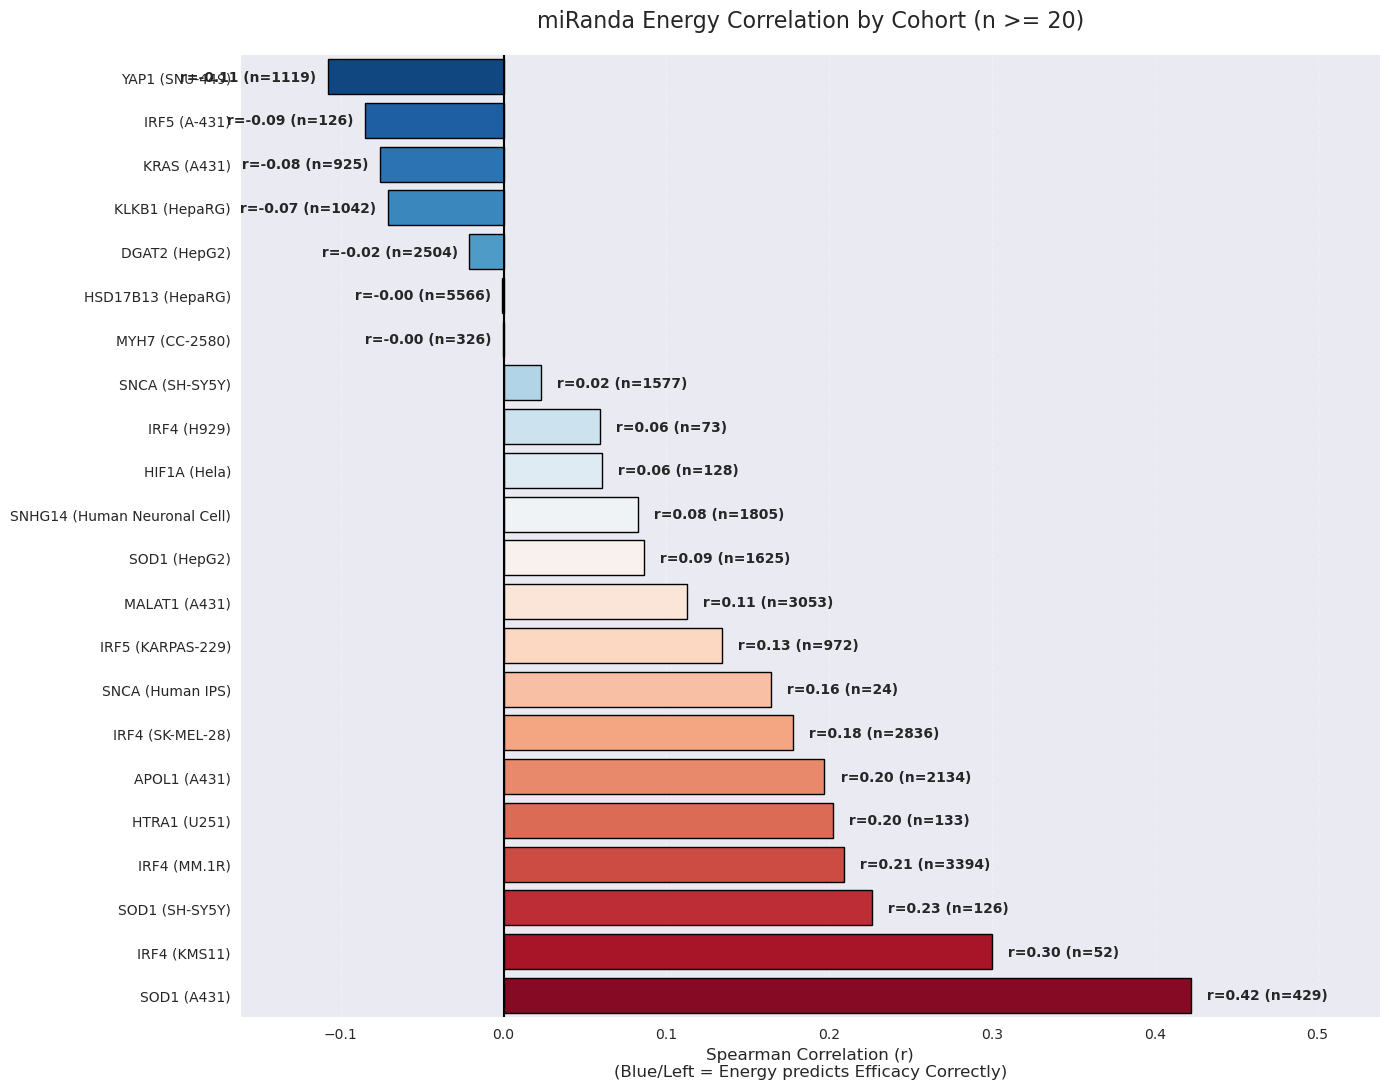

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from notebooks.consts import CANONICAL_GENE, INHIBITION

# --- CONFIGURATION ---
MIN_SAMPLES = 20
INHIBITION_COL = INHIBITION
FEATURE_COL = 'sfold_accessibility'  # Ensure this matches your column name
# ---------------------

# 1. Prepare Data
df_analysis = all_data_human_gene.dropna(subset=[INHIBITION_COL, FEATURE_COL]).copy()
df_analysis['Cohort'] = df_analysis[CANONICAL_GENE] + " (" + df_analysis['Cell_line'] + ")"

# 2. Calculate Correlation
cohort_stats = []
for cohort, group in df_analysis.groupby('Cohort'):
    if len(group) < MIN_SAMPLES: continue

    # Calculate Spearman (Negative r is GOOD for Energy)
    corr, p_val = spearmanr(group[FEATURE_COL], group[INHIBITION_COL])
    cohort_stats.append({
        'Cohort': cohort,
        'Spearman_r': corr,
        'Count': len(group)
    })

df_stats = pd.DataFrame(cohort_stats).sort_values('Spearman_r')

# 3. Visualization (Fixed Layout)
if not df_stats.empty:
    # Taller figure to prevent squishing
    plt.figure(figsize=(14, max(8, len(df_stats) * 0.5)))

    # Draw Bar Plot
    ax = sns.barplot(
        data=df_stats,
        x='Spearman_r',
        y='Cohort',
        palette='RdBu_r',
        edgecolor='black',
        saturation=1
    )

    plt.axvline(x=0, color='black', linewidth=1.5, linestyle='-')

    # --- FIX: Add padding to x-axis so text fits ---
    # Get current limits and expand them by 15%
    x_min, x_max = ax.get_xlim()
    ax.set_xlim(x_min * 1.2, x_max * 1.2)

    # Annotate bars
    for i, p in enumerate(ax.patches):
        val = df_stats.iloc[i]['Spearman_r']
        count = df_stats.iloc[i]['Count']

        # Smart Labeling:
        # If val is negative (left), put text to the left of the bar
        # If val is positive (right), put text to the right
        ha = 'right' if val < 0 else 'left'
        offset = -8 if val < 0 else 8

        ax.annotate(f" r={val:.2f} (n={count})",
                    (val, p.get_y() + p.get_height()/2),
                    va='center', ha=ha,
                    fontsize=10, fontweight='bold',
                    xytext=(offset, 0),
                    textcoords='offset points')

    plt.title(f"sfold Energy Correlation by Cohort (n >= {MIN_SAMPLES})", fontsize=16, pad=20)
    plt.xlabel("Spearman Correlation (r)\n(Blue/Left = Energy predicts Efficacy Correctly)", fontsize=12)
    plt.ylabel("") # Remove y-label to save space

    # Clean up spines for a pro look
    sns.despine(left=True, bottom=True)
    plt.grid(axis='x', alpha=0.3, linestyle='--')

    # --- FIX: Prevent cutting off labels ---
    plt.tight_layout()
    plt.show()

else:
    print("No cohorts met the criteria.")

In [ ]:
# ... (End of your existing Step 4) ...

# 5. Save Results
output_csv = "aso_sfold_results.csv"

# Save the full dataframe (including rows where calculation might have failed)
all_data_human_gene.to_csv(output_csv, index=False)

# Optional: Save a "clean" version with only successful calculations
clean_csv = "aso_sfold_results_clean.csv"
df_analyzed.to_csv(clean_csv, index=False)

print(f"Full data saved to: {output_csv}")
print(f"Clean data saved to: {clean_csv}")